In [ ]:
!pip3 install requests beautifulsoup4 lxml

In [ ]:
import requests
from bs4 import BeautifulSoup

base_url = 'https://blog.gov.bc.ca/bcwildfire/page/'
news_links = []


for page in range(1, 30):
    url = f'{base_url}{page}'
    
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to retrieve page {page}")
        break

    soup = BeautifulSoup(response.text, 'lxml')
    articles = soup.find_all('div', class_='post-feed-box')

    for article in articles:
        link = article.find('h1').find('a')['href']
        news_links.append(link)

In [1]:
from datetime import datetime

def convert_to_timestamp(date_str, date_format):
    date_obj = datetime.strptime(date_str, date_format)
    timestamp = int(date_obj.timestamp())
    return timestamp

In [ ]:
import pandas as pd

df = pd.DataFrame({"title": [], "date": [], "content": [], "link": []})

for link in news_links:
    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'lxml')
    title = soup.find('h1', class_="entry-title").text
    date = soup.find('time').text
    content = soup.find('div', class_='entry-content').text
    df.loc[len(df)] = {"title": title, "created_at": convert_to_timestamp(
        date, "%B %d, %Y"), "content": content, "link": link}


In [ ]:
df.to_csv('bc_wildfire_news.csv', index=False)

In [2]:
import emoji
import re

def clean_text(text):
    if not isinstance(text, str): return " "
    text = text.lower()
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [3]:
import pandas as pd

df = pd.read_csv('bc_wildfire_news.csv')
df['clean_content'] = df['content'].apply(clean_text)
df = df[df['created_at'] >= 1677654056]
df

,title,created_at,content,link,clean_content
0,Campfire Prohibition Partially Rescinded in No...,1694498400,\nSMITHERS – Effective at 12:00 p.m. (noon) on...,https://blog.gov.bc.ca/bcwildfire/cat1-partial...,smithers – effective at 12:00 p.m. (noon) on ...
1,Forecasted weather conditions expected to incr...,1694325600,\nPRINCE GEORGE – Weather conditions across th...,https://blog.gov.bc.ca/bcwildfire/forecasted-w...,prince george – weather conditions across the...
2,Area restriction for the Jubilee Mountain wild...,1694152800,\nCASTLEGAR– Effective immediately the Area Re...,https://blog.gov.bc.ca/bcwildfire/area-restric...,castlegar– effective immediately the area res...
3,Area Restriction implemented for Casper Creek ...,1694152800,\nKAMLOOPS – The BC Wildfire Service has imple...,https://blog.gov.bc.ca/bcwildfire/area-restric...,kamloops – the bc wildfire service has implem...
4,Area Restriction expanded for the Downton Lake...,1694152800,\nKAMLOOPS – The BC Wildfire Service has expan...,https://blog.gov.bc.ca/bcwildfire/area-restric...,kamloops – the bc wildfire service has expand...
...,...,...,...,...,...
188,Pile burns planned for Mill Creek Quarry site,1679637600,\nFORT NELSON—The BC Wildfire Service plans to...,https://blog.gov.bc.ca/bcwildfire/pile-burns-p...,fort nelson—the bc wildfire service plans to ...
189,Prescribed burn scheduled for Chu Chua,1679378400,\nKAMLOOPS – The BC Wildfire Service and Simpc...,https://blog.gov.bc.ca/bcwildfire/prescribed-b...,kamloops – the bc wildfire service and simpcw...
190,Pile burning in Myra Bellevue Park,1678431600,"\nKELOWNA – The BC Wildfire Service, in conjun...",https://blog.gov.bc.ca/bcwildfire/pile-burning...,"kelowna – the bc wildfire service, in conjunc..."
191,Prescribed burns scheduled for the Lytton Area,1678431600,"\nLYTTON – The BC Wildfire Service, Lytton Fir...",https://blog.gov.bc.ca/bcwildfire/prescribed-b...,"lytton – the bc wildfire service, lytton firs..."


time
2023-03-06    1
2023-03-10    2
2023-03-21    1
2023-03-24    1
2023-03-27    1
             ..
2023-09-05    4
2023-09-07    3
2023-09-08    4
2023-09-10    1
2023-09-12    1
Length: 101, dtype: int64


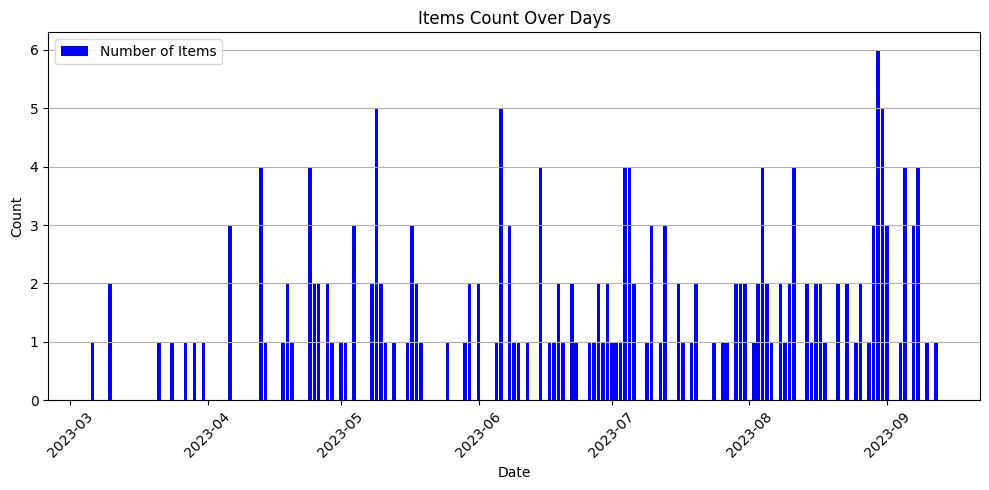

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df['time'] = pd.to_datetime(df['created_at'], unit='s')

daily_counts = df.groupby(df['time'].dt.date).size()
print(daily_counts)

plt.figure(figsize=(10, 5))
plt.bar(daily_counts.index, daily_counts, label='Number of Items', color='blue', width=0.8)

plt.title('Items Count Over Days')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
import pandas as pd
import random

nltk.download('stopwords')
nltk.download('punkt')


def topic_mining(selected_rows):
    texts = selected_rows['title'].tolist()

    stop_words = set(stopwords.words('english'))

    preprocessed_texts = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        filtered_words = [word for word in tokens if word.isalpha() and word not in stop_words]
        preprocessed_texts.append(filtered_words)


    dictionary = corpora.Dictionary(preprocessed_texts)
    corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]


    num_topics = 5
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)

    for topic_id in range(num_topics):
        topic_keywords = lda_model.show_topic(topic_id, topn=10)
        keyword_list = [keyword for keyword, _ in topic_keywords]
        print(f"Topic {topic_id + 1}: {', '.join(keyword_list)}")

        doc_topics = lda_model.get_document_topics(corpus)

        relevant_docs = [texts[i] for i, topics in enumerate(doc_topics) if any(topic[0] == topic_id for topic in topics)]

        print("Examples:")
        for doc in random.sample(relevant_docs, k=min(5, len(relevant_docs))):
            print(doc)
        print()

topic_mining(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alireza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Topic 1: fire, cariboo, prohibition, centre, category, planned, campfire, throughout, southeast, burn
Examples:
Area restriction amended for Mount Bingay wildfire
Prescribed burn planned for Selous Creek area
Direct vs. Indirect attack explained
Prescribed burn planned for Tŝideldel
Wildfire Risk Reduction burn planned near Fox Mountain

Topic 2: area, wildfire, restriction, effect, burn, creek, planned, category, rescinded, campfire
Examples:
Area Restriction in effect for vicinity of the Nilkitkwa FSR
Area restriction for the Mount Bingay wildfire rescinded
Forecasted weather conditions expected to increase fire activity
Provincial Wildfire Status Update – May 11, 2023
Category 2 Fire Prohibition Order for the Peace & Fort Nelson Forest Districts

Topic 3: fire, centre, wildfire, area, creek, planned, campfire, category, burn, restriction
Examples:
Area restriction for the Schofield Creek wildfire rescinded
Piles to be burned in Seymour Ridge area
Area Restriction extension for the R

In [43]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and not word.isdigit()]
    clean_text = ' '.join(filtered_words)
    clean_text = clean_text.lower()
    clean_text = re.sub(r'http\S+|www\S+', '', clean_text)
    clean_text = re.sub(r'@\S+', '', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text)
    return clean_text



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alireza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
tfidf_vectorizer = TfidfVectorizer(max_features=20)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['title'].apply(clean_text))

feature_names = tfidf_vectorizer.get_feature_names_out()

average_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]

term_tfidf_pairs = list(zip(feature_names, average_tfidf_scores))

sorted_terms = sorted(term_tfidf_pairs, key=lambda x: x[1], reverse=True)

top_keywords = [term for term, score in sorted_terms]

print("Top Keywords:")
print(top_keywords[:10])

Top Keywords:
['wildfire', 'area', 'restriction', 'fire', 'creek', 'update', 'provincial', 'status', 'centre', 'rescinded']


In [47]:
tfidf_vectorizer = TfidfVectorizer(max_features=20)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['content'].apply(clean_text))

feature_names = tfidf_vectorizer.get_feature_names_out()

average_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]

term_tfidf_pairs = list(zip(feature_names, average_tfidf_scores))

sorted_terms = sorted(term_tfidf_pairs, key=lambda x: x[1], reverse=True)

top_keywords = [term for term, score in sorted_terms]

print("Top Keywords:")
print(top_keywords[:10])

Top Keywords:
['wildfire', 'fire', 'bc', 'area', 'open', 'burning', 'service', 'creek', 'public', 'lake']


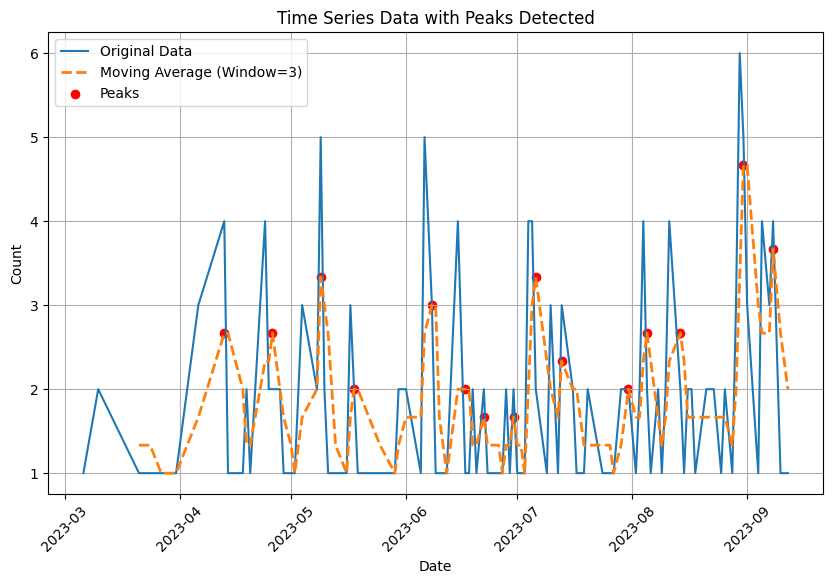

Dates of detected peaks:
Index([2023-04-13, 2023-04-26, 2023-05-09, 2023-05-18, 2023-06-08, 2023-06-17,
       2023-06-22, 2023-06-30, 2023-07-06, 2023-07-13, 2023-07-31, 2023-08-05,
       2023-08-14, 2023-08-31, 2023-09-08],
      dtype='object', name='time')


In [48]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

window_size = 3

time_series = pd.Series(daily_counts.values, index=daily_counts.index, name="Count")

moving_average = time_series.rolling(window=window_size).mean()

peaks, _ = find_peaks(moving_average, height=0)

plt.figure(figsize=(10, 6))
plt.plot(time_series.index, time_series.values, label="Original Data")
plt.plot(moving_average.index, moving_average.values, label=f"Moving Average (Window={window_size})", linestyle='--', linewidth=2)
plt.scatter(moving_average.index[peaks], moving_average.values[peaks], marker='o', color='red', label="Peaks")
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Time Series Data with Peaks Detected")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

print("Dates of detected peaks:")
print(moving_average.index[peaks])

In [50]:
from datetime import datetime, timedelta

for peak in peaks:
    peak_posts = df[df['time'].dt.date == moving_average.index[peak]]
    for i in range(1, 3):
        date = moving_average.index[peak] - timedelta(days=i)
        day_posts = df[df['time'].dt.date == date]
        peak_posts = pd.concat([peak_posts, day_posts])

    print(f"Peak {peak + 1}: {moving_average.index[peak]}")

    tfidf_vectorizer = TfidfVectorizer(max_features=20)
    tfidf_matrix = tfidf_vectorizer.fit_transform(peak_posts['title'].apply(clean_text))
    feature_names = tfidf_vectorizer.get_feature_names_out()
    average_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]
    term_tfidf_pairs = list(zip(feature_names, average_tfidf_scores))
    sorted_terms = sorted(term_tfidf_pairs, key=lambda x: x[1], reverse=True)
    top_keywords = [term for term, score in sorted_terms]
    print("Top Keywords:")
    print(top_keywords)
    tfidf_vectorizer = TfidfVectorizer(max_features=20)
    tfidf_matrix = tfidf_vectorizer.fit_transform(peak_posts['content'].apply(clean_text))
    feature_names = tfidf_vectorizer.get_feature_names_out()
    average_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]
    term_tfidf_pairs = list(zip(feature_names, average_tfidf_scores))
    sorted_terms = sorted(term_tfidf_pairs, key=lambda x: x[1], reverse=True)
    top_keywords = [term for term, score in sorted_terms]
    print("Top Keywords:")
    print(top_keywords)


Peak 9: 2023-04-13
Top Keywords:
['burn', 'prescribed', 'chimney', 'lake', 'april', 'outlook', 'spring', 'wildfire', 'fox', 'mountain', 'planned', 'bellevue', 'burning', 'myra', 'park', 'pile']
Top Keywords:
['wildfire', 'bc', 'burning', 'lake', 'fire', 'service', 'prescribed', 'smoke', 'burn', 'conditions', 'spring', 'burns', 'april', 'early', 'caused', 'cent', 'per', 'weather', 'drought', 'human']
Peak 16: 2023-04-26
Top Keywords:
['burn', 'planned', 'area', 'prescribed', 'ecosystem', 'restoration', 'creek', 'tŝideldel', 'near', 'springs', 'across', 'outdoor', 'strong', 'urged', 'use', 'winds', 'salisbury', 'trozzo', 'upper', 'winlaw']
Top Keywords:
['wildfire', 'fire', 'burn', 'burning', 'prescribed', 'http', 'smoke', 'bc', 'conditions', 'open', 'service', 'reduce', 'com', 'may', 'information', 'facebook', 'twitter', 'area', 'latest', 'site']
Peak 23: 2023-05-09
Top Keywords:
['burn', 'fire', 'wildfire', 'planned', 'category', 'regulation', 'centre', 'prohibition', 'prescribed', 'su

In [51]:
all_keywords

{'122',
 '126',
 '50',
 '54',
 'act',
 'activity',
 'along',
 'april',
 'area',
 'attack',
 'augier',
 'bc',
 'bellevue',
 'boundary',
 'burn',
 'burning',
 'burns',
 'ca',
 'campfire',
 'category',
 'caused',
 'cent',
 'centre',
 'centren',
 'chimney',
 'coast',
 'com',
 'conditions',
 'coordinate',
 'creek',
 'current',
 'defensible',
 'direct',
 'district',
 'drought',
 'early',
 'east',
 'exceeding',
 'facebook',
 'fire',
 'fires',
 'firesmart',
 'follow',
 'forest',
 'fox',
 'free',
 'fsr',
 'fuel',
 'george',
 'height',
 'home',
 'http',
 'human',
 'indirect',
 'information',
 'july',
 'junction',
 'june',
 'kilometres',
 'lake',
 'latest',
 'local',
 'material',
 'may',
 'mountain',
 'myra',
 'north',
 'one',
 'open',
 'order',
 'outlook',
 'park',
 'per',
 'pile',
 'planned',
 'point',
 'prescribed',
 'prohibited',
 'prohibition',
 'property',
 'protection',
 'province',
 'provincial',
 'public',
 'reduce',
 'remain',
 'rescinded',
 'resource',
 'resources',
 'restriction',
 'r

In [55]:
!pip3 install transformers
!pip3 install bert-extractive-summarizer
!pip3 install spacy



Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement 

In [12]:
from summarizer import Summarizer,TransformerSummarizer

body = df.iloc[0]['content']

paragraphs = [paragraph for paragraph in body.split('\n\n') if paragraph.strip()]
extra = ["contact", "for more information", "call", "twitter", "instagram", "facebook", "download", "for update"]
new_paragraphs = [paragraph for paragraph in paragraphs if not any(keyword in paragraph.lower() for keyword in extra)]

body = '\n'.join(new_paragraphs)

bert_model = Summarizer()
bert_summary = ''.join(bert_model(body, min_length=60))
print(bert_summary)

# GPT2_model = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")
# full = ''.join(GPT2_model(body, min_length=60))
# print(full)

2023-10-02 11:55:56.674772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 11:55:57.736662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


SMITHERS – Effective at 12:00 p.m. (noon) on Tuesday, September 12, 2023, the Category 1 campfire prohibition was rescinded in the Cassiar Fire Zone, Skeena Fire Zone and Bulkley Fire Zone. Category 2 and Category 3 open burning remain prohibited across the entire Northwest Fire Centre, in addition to the use of:
fireworks, including firecrackers, and
sky lanterns.


/home/alireza/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
import nltk
from nltk.tokenize import sent_tokenize

def summarize(body):
    bert_summary = ''.join(bert_model(body, min_length=60))
    return bert_summary

extra = ["contact", "for more information", "call", "twitter", "instagram", "facebook", "download", "for update"]
def remove_extra(body):
    sentences = sent_tokenize(body)
    new_sentences = [sen for sen in sentences if not any(keyword in sen.lower() for keyword in extra)]
    body = '\n'.join(new_sentences)
    return body


df['summary'] = df['content'].apply(remove_extra).apply(summarize)

/home/alireza/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/alireza/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/alireza/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/alireza/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'au

In [15]:
df

,title,created_at,content,link,clean_content,time,summary
0,Campfire Prohibition Partially Rescinded in No...,1694498400,\nSMITHERS – Effective at 12:00 p.m. (noon) on...,https://blog.gov.bc.ca/bcwildfire/cat1-partial...,smithers – effective at 12:00 p.m. (noon) on ...,2023-09-12 06:00:00,SMITHERS – Effective at 12:00 p.m. (noon) on T...
1,Forecasted weather conditions expected to incr...,1694325600,\nPRINCE GEORGE – Weather conditions across th...,https://blog.gov.bc.ca/bcwildfire/forecasted-w...,prince george – weather conditions across the...,2023-09-10 06:00:00,PRINCE GEORGE – Weather conditions across the ...
2,Area restriction for the Jubilee Mountain wild...,1694152800,\nCASTLEGAR– Effective immediately the Area Re...,https://blog.gov.bc.ca/bcwildfire/area-restric...,castlegar– effective immediately the area res...,2023-09-08 06:00:00,CASTLEGAR– Effective immediately the Area Rest...
3,Area Restriction implemented for Casper Creek ...,1694152800,\nKAMLOOPS – The BC Wildfire Service has imple...,https://blog.gov.bc.ca/bcwildfire/area-restric...,kamloops – the bc wildfire service has implem...,2023-09-08 06:00:00,KAMLOOPS – The BC Wildfire Service has impleme...
4,Area Restriction expanded for the Downton Lake...,1694152800,\nKAMLOOPS – The BC Wildfire Service has expan...,https://blog.gov.bc.ca/bcwildfire/area-restric...,kamloops – the bc wildfire service has expand...,2023-09-08 06:00:00,KAMLOOPS – The BC Wildfire Service has expande...
...,...,...,...,...,...,...,...
188,Pile burns planned for Mill Creek Quarry site,1679637600,\nFORT NELSON—The BC Wildfire Service plans to...,https://blog.gov.bc.ca/bcwildfire/pile-burns-p...,fort nelson—the bc wildfire service plans to ...,2023-03-24 06:00:00,FORT NELSON—The BC Wildfire Service plans to u...
189,Prescribed burn scheduled for Chu Chua,1679378400,\nKAMLOOPS – The BC Wildfire Service and Simpc...,https://blog.gov.bc.ca/bcwildfire/prescribed-b...,kamloops – the bc wildfire service and simpcw...,2023-03-21 06:00:00,KAMLOOPS – The BC Wildfire Service and Simpcw ...
190,Pile burning in Myra Bellevue Park,1678431600,"\nKELOWNA – The BC Wildfire Service, in conjun...",https://blog.gov.bc.ca/bcwildfire/pile-burning...,"kelowna – the bc wildfire service, in conjunc...",2023-03-10 07:00:00,"KELOWNA – The BC Wildfire Service, in conjunct..."
191,Prescribed burns scheduled for the Lytton Area,1678431600,"\nLYTTON – The BC Wildfire Service, Lytton Fir...",https://blog.gov.bc.ca/bcwildfire/prescribed-b...,"lytton – the bc wildfire service, lytton firs...",2023-03-10 07:00:00,"LYTTON – The BC Wildfire Service, Lytton First..."


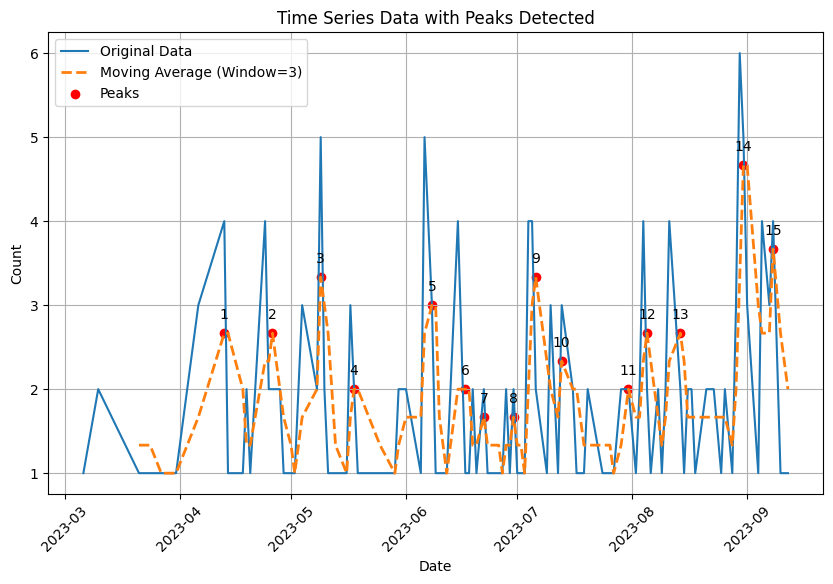

Peak 1: 2023-04-13
                                        title
178        Pile burning in Myra Bellevue Park
179        April 2023 Spring Wildfire Outlook
180          Prescribed burn for Chimney Lake
181  Prescribed burn planned for Fox Mountain
Peak 2: 2023-04-26
                                                 title
165   Public urged to use caution when outdoor burning
166  Strong winds forecasted across Cariboo Fire Ce...
167  Ecosystem restoration burn planned for Lost Sp...
168     Ecosystem restoration burn planned near ʔaq̓am
169  Prescribed burn planned for Salisbury Creek ar...
170  Ecosystem restoration burn planned for Upper W...
171      Prescribed burn planned for Trozzo Creek area
172              Prescribed burn planned for Tŝideldel
Peak 3: 2023-05-09
                                                 title
150  Category 2 Fire Prohibition planned for Caribo...
151  Category 2 and Category 3 open fire prohibitio...
152  Prescribed burn planned for the Sutherland Cre..

In [57]:
from datetime import  timedelta

plt.figure(figsize=(10, 6))
plt.plot(time_series.index, time_series.values, label="Original Data")
plt.plot(moving_average.index, moving_average.values, label=f"Moving Average (Window={window_size})", linestyle='--', linewidth=2)
plt.scatter(moving_average.index[peaks], moving_average.values[peaks], marker='o', color='red', label="Peaks")
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Time Series Data with Peaks Detected")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
for i, peak in enumerate(peaks):
    plt.annotate(f"{i+1}", (moving_average.index[peak], moving_average.values[peak]),
                 textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

all_peak_posts = pd.DataFrame(columns=df.columns)
for i, peak in enumerate(peaks):
    peak_posts = df[df['time'].dt.date == moving_average.index[peak]]
    for j in range(1, 3):
        date = moving_average.index[peak] - timedelta(days=j)
        day_posts = df[df['time'].dt.date == date]
        peak_posts = pd.concat([peak_posts, day_posts])
    all_peak_posts = pd.concat([all_peak_posts, peak_posts])

    print(f"Peak {i + 1}: {moving_average.index[peak]}")
    print(peak_posts[['title']])



/home/alireza/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/alireza/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/alireza/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/alireza/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'au

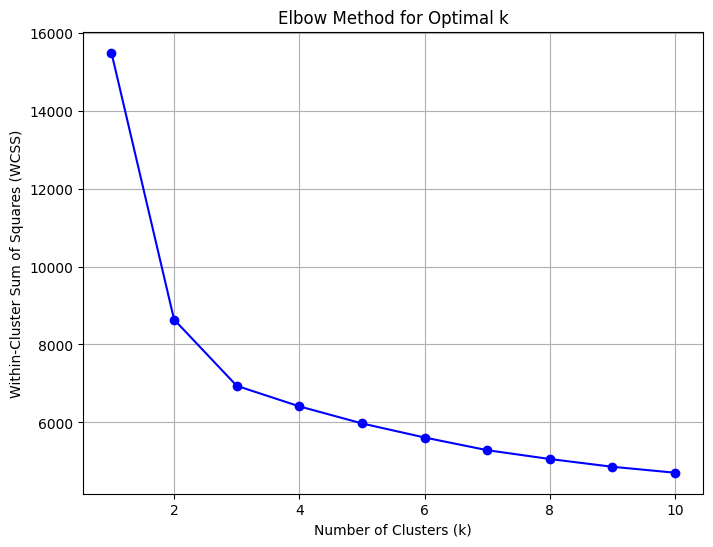

In [14]:
import numpy as np
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
import torch
import re

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

corpus = df['summary'].tolist()

document_embeddings = []
for document in corpus:
    document = re.sub(r'\W', ' ', document)
    tokens = tokenizer.tokenize(document)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    max_length = 128
    input_ids = input_ids[:max_length] + [0] * (max_length - len(input_ids))
    
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    
    with torch.no_grad():
        embeddings = model(input_ids)

    cls_embedding = embeddings.last_hidden_state[:, 0, :].numpy()
    
    document_embeddings.append(cls_embedding)
k_values = range(1, 11)
wcss_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(np.vstack(document_embeddings))
    wcss_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

In [16]:
num_clusters = 9
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(np.vstack(document_embeddings))

# df_cp = df.copy()

# df_cp['summary'] = df['summary']
# df_cp.to_csv('news_cluster.csv')


/home/alireza/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [64]:
from sklearn.feature_extraction.text import CountVectorizer

top_keywords_per_cluster = []
all_keywords = {'public', 'per', 'restriction', 'myra', 'bellevue', 'update', 'outlook', 'mountain', 'rescinded', 'centre', 'smoke', 'service', 'fire', 'bc', 'wildfire', 'burning', 'burn', 'weather', 'spring', 'caused', 'open', 'area', 'drought', 'provincial', 'early', 'planned', 'burns', 'april', 'prescribed', 'fox', 'creek', 'human', 'cent', 'status', 'pile', 'lake', 'conditions', 'park', 'chimney'}

for i in range(num_clusters):
    cluster = peaks_topic_df[peaks_topic_df['topic'] == i]
    cluster_text = ' '.join(cluster['title'].apply(clean_text).tolist())

    vectorizer = CountVectorizer()
    term_frequency = vectorizer.fit_transform([cluster_text])
    
    # Get the terms and their frequencies
    terms = vectorizer.get_feature_names_out()
    term_frequencies = np.array(term_frequency.sum(axis=0)).ravel()
    
    # Sort terms by frequency in descending order
    sorted_indices = np.argsort(term_frequencies)[::-1]
    sorted_terms = [terms[i] for i in sorted_indices]
    
    top_keywords = sorted_terms[:10]
    
    top_keywords_per_cluster.append(top_keywords)

top_keywords_per_cluster
for i, top_keywords in enumerate(top_keywords_per_cluster):
    all_keywords |= set(top_keywords)

In [56]:
for i, peak in enumerate(peaks):
    peak_posts = peaks_topic_df[peaks_topic_df['time'].dt.date == moving_average.index[peak]]
    for j in range(1, 3):
        date = moving_average.index[peak] - timedelta(days=j)
        day_posts = peaks_topic_df[peaks_topic_df['time'].dt.date == date]
        peak_posts = pd.concat([peak_posts, day_posts])

    print(f"Peak {i + 1}: {moving_average.index[peak]}")
    print(peak_posts['topic'].value_counts())

Peak 1: 2023-04-13
topic
5    2
3    1
2    1
Name: count, dtype: int64
Peak 2: 2023-04-26
topic
3    3
5    3
4    1
0    1
Name: count, dtype: int64
Peak 3: 2023-05-09
topic
3    3
4    2
5    1
2    1
Name: count, dtype: int64
Peak 4: 2023-05-18
topic
3    4
2    1
5    1
Name: count, dtype: int64
Peak 5: 2023-06-08
topic
2    2
0    2
1    1
3    1
4    1
5    1
Name: count, dtype: int64
Peak 6: 2023-06-17
topic
3    2
1    1
2    1
0    1
Name: count, dtype: int64
Peak 7: 2023-06-22
topic
3    1
2    1
5    1
Name: count, dtype: int64
Peak 8: 2023-06-30
topic
4    1
3    1
2    1
5    1
1    1
Name: count, dtype: int64
Peak 9: 2023-07-06
topic
3    5
2    2
1    1
4    1
0    1
Name: count, dtype: int64
Peak 10: 2023-07-13
topic
5    2
2    1
3    1
Name: count, dtype: int64
Peak 11: 2023-07-31
topic
1    3
3    1
2    1
0    1
Name: count, dtype: int64
Peak 12: 2023-08-05
topic
1    6
2    1
3    1
Name: count, dtype: int64
Peak 13: 2023-08-14
topic
2    1
1    1
Name: count, dty

In [65]:
with open('BC_Entities.txt', "r") as file:
    entities = file.read().split("\n")

entities = set(entities)
entities = sorted(entities, key=str.lower)
entities = [entity.lower() for entity in entities]

with open('BC_Entities.txt', "w") as file:
    file.write("\n".join(entities))

with open('bc_wildfire_news.csv', "r") as file:
    bc_news = file.read()

impacted_entities = []
for entity in entities:
    if entity in bc_news.lower():
        impacted_entities.append(entity)

print(entities)
print(impacted_entities)

all_keywords |= set(impacted_entities)

['100 mile house', 'abbotsford', 'alaska highway', 'aldergrove', 'alert bay', 'alexis creek', 'alice arm - kitsault', 'anahim lake', 'anmore', 'argenta', 'armstrong', 'ashcroft', 'atlin', 'avola', 'balfour', 'bamfield', 'barkerville', 'barnston island', 'barriere', 'beaverdell', 'belcarra', 'bell ii', 'bella bella', 'bella coola', 'blue river', 'boston bar', 'boswell', 'bowen island', 'bralorne', 'bridesville', 'britannia beach', 'burnaby', 'burns lake', 'cache creek', 'campbell river', 'canal flats', 'cariboo chilcotin coast', 'cassiar', 'cassidy', 'castlegar', 'cawston', 'cedar', 'central saanich', 'chase', 'chemainus', 'cherryville', 'chetwynd', 'chilanko forks', 'chilliwack', 'christina lake', 'clearwater', 'clinton', 'cloverdale', 'coalmont', 'cobble hill', 'coldstream', 'colwood', 'comox', 'coombs', 'coquitlam', 'cortes island', 'courtenay', 'cowichan bay', 'craigellachie', 'cranbrook', 'crawford bay', 'crescent valley', 'creston', 'crofton', 'cultus lake', 'cumberland', "d'arcy"

In [66]:
all_keywords

{'100 mile house',
 'alaska highway',
 'alexis creek',
 'april',
 'area',
 'argenta',
 'august',
 'balfour',
 'barriere',
 'bc',
 'bellevue',
 'blue river',
 'boston bar',
 'burn',
 'burning',
 'burns',
 'burns lake',
 'cache creek',
 'campfire',
 'canal flats',
 'cassiar',
 'castlegar',
 'category',
 'caused',
 'caution',
 'cedar',
 'cent',
 'centre',
 'chetwynd',
 'chilanko forks',
 'chilliwack',
 'chimney',
 'christina lake',
 'clinton',
 'coastal',
 'complex',
 'conditions',
 'cranbrook',
 'crawford bay',
 'creek',
 'dawson creek',
 'drought',
 'duncan',
 'early',
 'effect',
 'elkford',
 'enacts',
 'endako',
 'fauquier',
 'fernie',
 'field',
 'fire',
 'fort nelson',
 'fort st. james',
 'fort st. john',
 'fox',
 'fraser lake',
 'george',
 'gold bridge',
 'golden',
 'grand forks',
 'hanceville',
 'hedley',
 'highlands',
 'hills',
 'hope',
 'horsefly',
 'human',
 'invermere',
 'july',
 'june',
 'kamloops',
 'kaslo',
 'kelowna',
 'keremeos',
 'kimberley',
 'lake',
 'liard river',
 'lik

In [67]:
impacted_entities

['100 mile house',
 'alaska highway',
 'alexis creek',
 'argenta',
 'balfour',
 'barriere',
 'blue river',
 'boston bar',
 'burns lake',
 'cache creek',
 'canal flats',
 'cassiar',
 'castlegar',
 'cedar',
 'chetwynd',
 'chilanko forks',
 'chilliwack',
 'christina lake',
 'clinton',
 'cranbrook',
 'crawford bay',
 'dawson creek',
 'duncan',
 'elkford',
 'endako',
 'fauquier',
 'fernie',
 'field',
 'fort nelson',
 'fort st. james',
 'fort st. john',
 'fraser lake',
 'gold bridge',
 'golden',
 'grand forks',
 'hanceville',
 'hedley',
 'highlands',
 'hills',
 'hope',
 'horsefly',
 'invermere',
 'kamloops',
 'kaslo',
 'kelowna',
 'keremeos',
 'kimberley',
 'liard river',
 'likely',
 'lillooet',
 'lower post',
 'lumby',
 'lytton',
 'mackenzie',
 'mcbride',
 'meadow creek',
 'midway',
 'mission',
 'moberly lake',
 'moyie',
 'muncho lake',
 'nakusp',
 'naramata',
 'needles',
 'nelson',
 'new denver',
 'oliver',
 'osoyoos',
 'parksville',
 'peachland',
 'pemberton',
 'penticton',
 'prince georg